<p style="background:#C1524B; color:white; font-size: 2.1em; text-align:center"> 
    <br><br><b> Stroke Prediction Dataset</b><br><br><br>
</p>

<p style="text-align: right;">Module 3: Machine Learning<br>
Sprint 2: Gradient Boosted Trees & Feature Engineering<br>
Author : Renato Mariano</p>

<img src="stroke_img.jpg" width=300>

<h1 style="color:#C1524B">Introduction </h1>

This project will utilize a publicly available dataset from Kaggle. The dataset in question is the Stroke Prediction Dataset, which can be found on https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data.

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

<h2 style="color:#C1524B">Objectives </h2>

The objective of this notebook is to guide you through an analysis of the dataset and to **create a machine learning model that predicts which patients are more likely to get a stroke**.

This predictive model will allow **doctors to advise risk patients and their families on how to act in case of an emergency**.

<h2 style="color:#C1524B">Proposed Questions </h2>

The following questions have guided this analysis:
1. How are the features distributed?
2. Are age, hypertension and body mass index (BMI) impacting factors on having a stroke?
3. Can smoke increase the chances of strokes?
4. Are there significant differences between genders in this regard?
5. Do heart problems influence strokes?

<h2 style="color:#C1524B">Library Imports and Notebook Setup</h2>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from IPython.display import Image
from suplement_functions import (create_countplot_vertical, create_catplot, find_percentages_with_hue)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_confusion_matrix

from feature_engine.imputation import CategoricalImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap


In [ ]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h1 style="color:#C1524B">Exploratory Data Analysis</h1>

<h2 style="color:#C1524B">Initial Exploration</h2>

Let's start by reading our dataset and initially exploring its characteristics.

In [ ]:
stroke_df = pd.read_csv("data/healthcare-dataset-stroke-data.csv", index_col=0)
stroke_df.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.000,0,1,Yes,Private,Urban,228.690,36.600,formerly smoked,1
51676,Female,61.000,0,0,Yes,Self-employed,Rural,202.210,NaN,never smoked,1
31112,Male,80.000,0,1,Yes,Private,Rural,105.920,32.500,never smoked,1
60182,Female,49.000,0,0,Yes,Private,Urban,171.230,34.400,smokes,1
1665,Female,79.000,1,0,Yes,Self-employed,Rural,174.120,24.000,never smoked,1


In [ ]:
print(f"The shape of the data is: {stroke_df.shape}\n")
print(stroke_df.info())

The shape of the data is: (5110, 11)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB
None


In [ ]:
print(f"BMI has {stroke_df['bmi'].isna().sum()*100/stroke_df['bmi'].count():.1f}% of null rows")

BMI has 4.1% of null rows


Our initial exploration shows that the **dataframe is composed by 12 features and only present null values on BMI (4.1%)**.

The dataset presents both **categorical and numerical** features:
- Binary Categorical Features: hypertension, heart_disease, ever_married, Residence_type, stroke
- Multi-categorical Features: gender, work_type,  smoking_status
- Continous Numerical Features: age, avg_glucose_level, bmi

Let's take a look at the **dataset description**.

In [ ]:
stroke_df.describe() #[['age','avg_glucose_level', 'bmi']]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000,5110.000,5110.000,5110.000,4909.000,5110.000
mean,43.227,0.097,0.054,106.148,28.893,0.049
std,22.613,0.297,0.226,45.284,7.854,0.215
min,0.080,0.000,0.000,55.120,10.300,0.000
25%,25.000,0.000,0.000,77.245,23.500,0.000
50%,45.000,0.000,0.000,91.885,28.100,0.000
75%,61.000,0.000,0.000,114.090,33.100,0.000
max,82.000,1.000,1.000,271.740,97.600,1.000


In [ ]:
stroke_df.describe(include=["object"]).T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


The average age for the patients in the dataset is 43. This average is 106.1 for the glucose level and 28.9 for the Body Mass Index (BMI). This **mean BMI is in a overweight area**.

The top values in the categorical features are **females**, people who have already been **married**, people with a **private work**, living in **urban settlements** or/and who **never smoked**.

The features **'hypertension','heart_disease' and 'stroke'** don't provide direct interesting insights since they are categorical represented as integer.

<br>As shown bellow, the dataset presents **no duplicated patients**.

In [ ]:
stroke_df[stroke_df.duplicated()].head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,


<h2 style="color:#C1524B">Univariate Analysis of Features</h2>

What proportion of the pacients in the dataset have had a stroke?

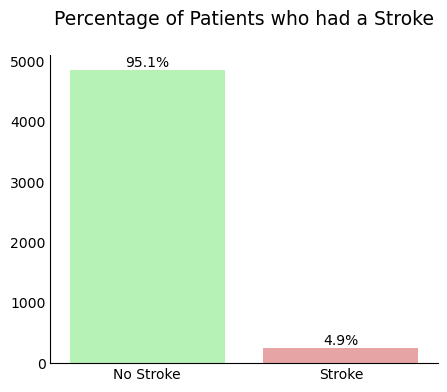

In [ ]:
df = stroke_df['stroke'].value_counts().to_frame().reset_index()
percentage = round(100*df['stroke']/sum(df['stroke']),1).tolist()
percentage = [f"{x}%" for x in percentage]

fig, ax = plt.subplots(figsize=(5, 4))
create_countplot_vertical(df=stroke_df, ax=ax, col="stroke", colors=['palegreen', 'lightcoral'], percent=percentage)

ax.set_title(f"Percentage of Patients who had a Stroke\n", fontsize=13.5)
ax.set_xticklabels(['No Stroke', 'Stroke']);


<p style = "background:	#f6eeee; color:black">We see that our target column is <b>extremely unbalanced</b>. 5 out of 100 patients in our dataset have had a stroke.<br>
These kind of situations occur often in the medical domain.<br><br>
Practically this means that a very simple model could already reach an execellent accuracy score, but probably very low levels of recall and precision will be obtained. Before diving into the modeling this should be taken into consideration. </p>

Let's take a look at the **distribution of the other categorical features**. Before, let's simply define the different types of features in the dataset.

In [ ]:
num_features = ["age", "avg_glucose_level", "bmi"]

binary_features = [
    "hypertension",
    "heart_disease",
    "ever_married",
    "Residence_type",
    "stroke",
]
cat_features = ["gender", "work_type", "smoking_status"]

palette_plt = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:grey",
    "tab:olive",
    "tab:cyan",
]

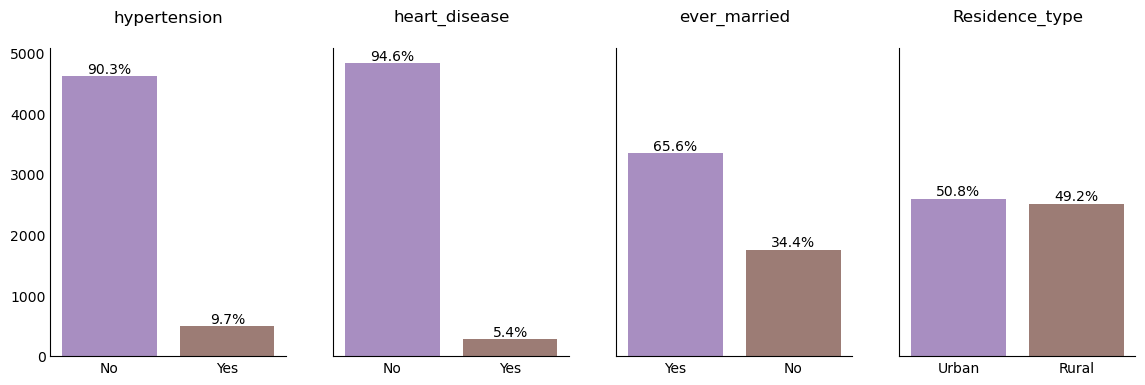

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True)

for i, col in enumerate(binary_features[:4]):
    list_counts = stroke_df[col].value_counts()[stroke_df[col].unique()].values
    percentage = [round(100*list_counts[i]/sum(list_counts),1) for i in range(len(list_counts))]
    percentage = [f"{x}%" for x in percentage]
    
    create_countplot_vertical(df=stroke_df, ax=axes[i], col=col, colors=palette_plt[4:], percent=percentage)
    axes[i].set(title=f"{col}\n")

axes[0].set_xticklabels(['No', 'Yes'])
axes[1].set_xticklabels(['No', 'Yes']);

The distribution of these variables showed that ca. **10 patients out of 100 have hypertension**. The proportion goes to **5 out 100 in the case of heart diseases.**

Most of the patients have been married and 51% are residents of urban settlements.

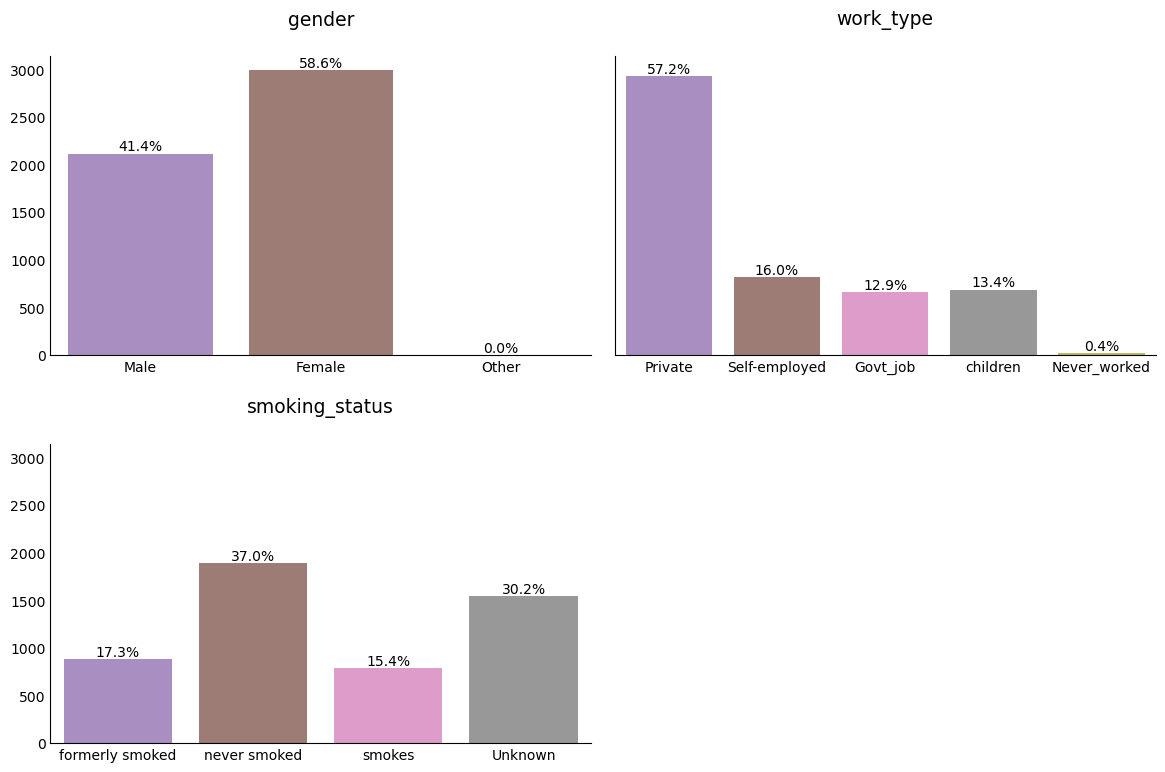

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes[1][1].axis('off')

for i, col in enumerate(cat_features):
    list_counts = stroke_df[col].value_counts()[stroke_df[col].unique()].values
    percentage = [round(100*list_counts[i]/sum(list_counts),1) for i in range(len(list_counts))]
    percentage = [f"{x}%" for x in percentage]

    create_countplot_vertical(df=stroke_df, ax=axes[i // 2][i % 2], col=col, colors=palette_plt[4:], percent=percentage)
    axes[i // 2][i % 2].set_title(f"{col}\n", fontsize=13.5)
    
plt.tight_layout(pad=1.7)

**Most of the pacients are women (59%) and man (41%)**, the presence of non-gender conforming people is almost null (only 1 patient).

The patients **work mostly in the private sector (57%)** followed by self-employed people.

The **smoking status present uncertainties** coming from the unknown category (30%), most of the patients never smoked (37%) or formerly smoked (17%); current smoker represent 15%.

Next is the **distribution of the numerical features**.

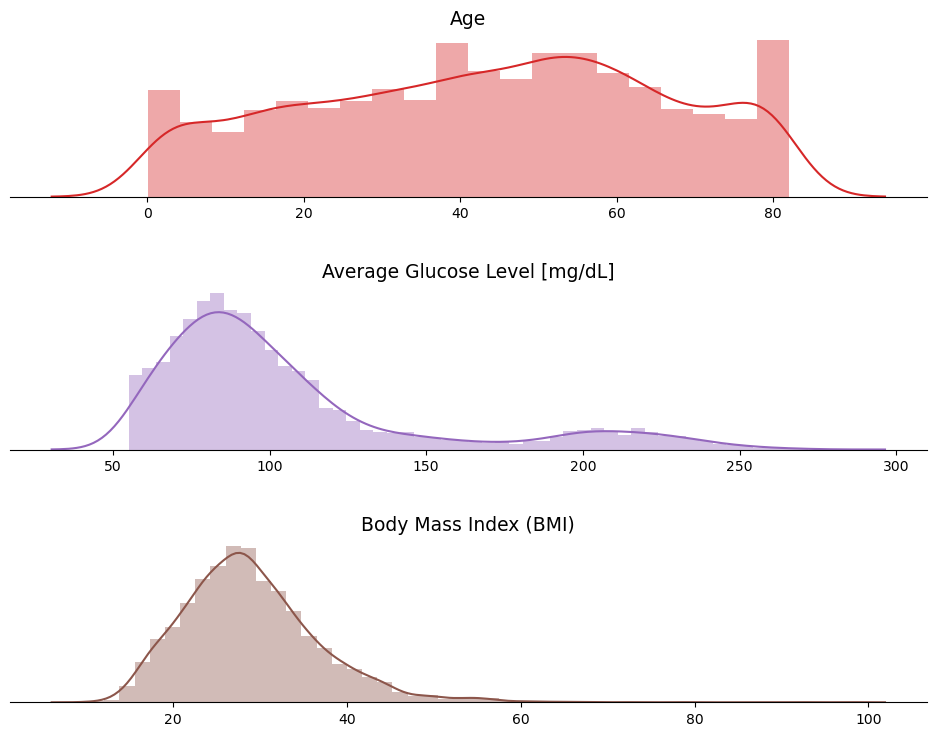

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, col in enumerate(num_features):
    sns.distplot(x=stroke_df[col], ax=axes[i], color=palette_plt[i+3])
    sns.despine(left=True)
    
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticklabels("")
    axes[i].tick_params(axis='y',length=0)

axes[0].set_title("Age", fontsize=13.5)
axes[1].set_title("Average Glucose Level [mg/dL]", fontsize=13.5)
axes[2].set_title("Body Mass Index (BMI)", fontsize=13.5)

plt.tight_layout(pad=3)

The **age range** for the patients goes from **infants to elderly** people, with most of the patients are adults (median value = 43). The feature **does not follow a normal distribution**.

**Glucose** Levels vary between ca. **70 and 290 mgl/dL**. The expected values for normal fasting blood glucose concentration are between 70 mg/dL and 100 mg/dL.

From the **BMI** distribution one can assume that a big proportion of the **patients are overweight** (BMI > 25).

<h2 style="color:#C1524B">Multivariate Analysis of Features</h2>

Let's start this part by checking how the **distribution of the continous features above relate to our target**.

Important to notice that the following plots **only show proportions of the dataset, not correlation**!!

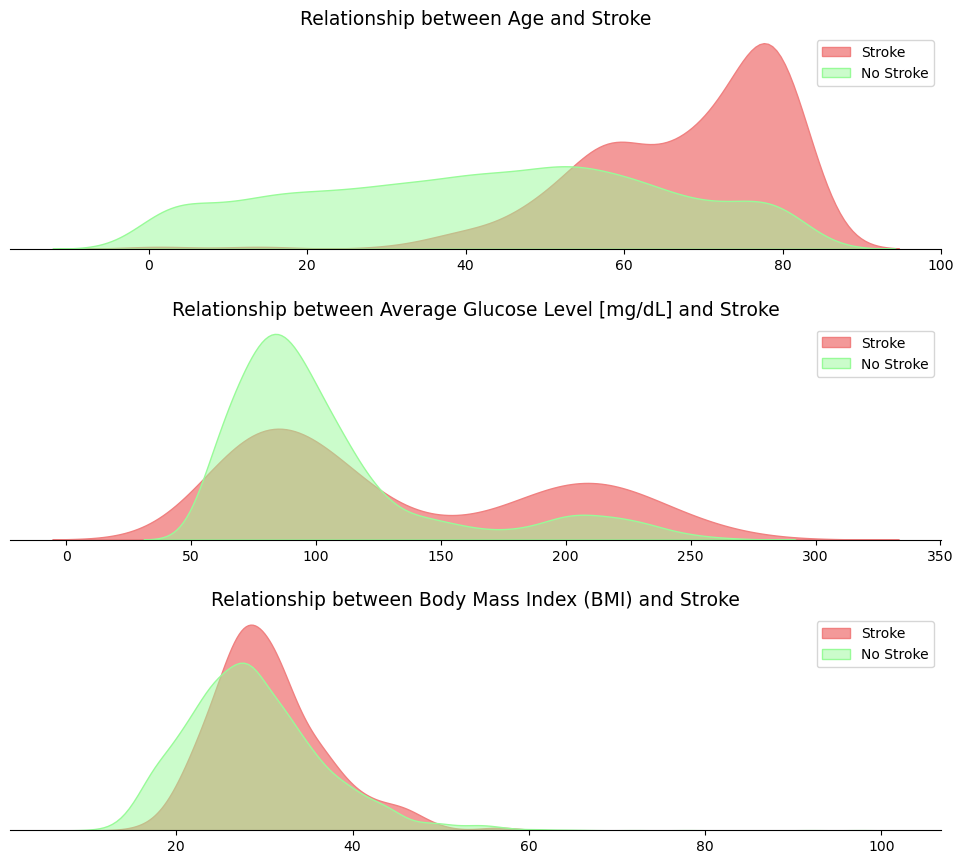

In [ ]:
legend_labels = ["Stroke", "No Stroke"]

fig, axes = plt.subplots(3, 1, figsize=(10, 9))

for i, col in enumerate(num_features):
    sns.kdeplot(
        data=stroke_df[stroke_df["stroke"] == 1],
        x=col,
        ax=axes[i],
        shade=True,
        color="lightcoral",
        alpha=0.8,
    )
    sns.kdeplot(
        data=stroke_df[stroke_df.stroke == 0],
        x=col,
        ax=axes[i],
        shade=True,
        color="palegreen",
        alpha=0.5,
    )
    sns.despine(left=True)

    axes[i].set_yticklabels("")
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].tick_params(axis="y", length=0)
    axes[i].legend(legend_labels, loc="upper right")

axes[0].set_title("Relationship between Age and Stroke", fontsize=13.5)
axes[1].set_title("Relationship between Average Glucose Level [mg/dL] and Stroke", fontsize=13.5)
axes[2].set_title("Relationship between Body Mass Index (BMI) and Stroke", fontsize=13.5)

plt.tight_layout(pad=2)

**The older a person is, the more likely** they can have a **stroke**.

In regards to the **glucose level, people with this parameter in normal ranges are less likely** to have strokes.

There is no **clear relationship between BMI and stroke** (there could be though, **trend is similar**).

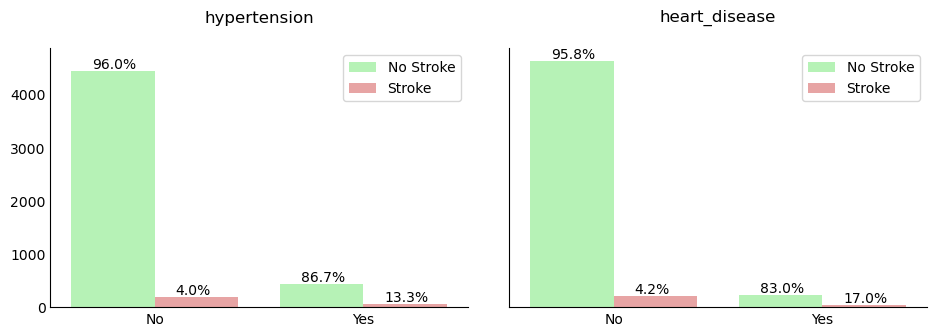

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for i, col in enumerate(binary_features[:2]):
    create_catplot(df=stroke_df, ax=axes[i], col=col, hue_col="stroke", colors=['palegreen', 'lightcoral'])
    find_percentages_with_hue(ax=axes[i], col=stroke_df[col])
    
    axes[i].legend(["No Stroke", "Stroke"])
    axes[i].set(title=f"{col}\n")
    axes[i].set_xticklabels(['No', 'Yes'])

plt.tight_layout(pad=3)

From the above plots one can see that there a **higher chance to have strokes** amongst the groups of **people with hypertension and with problems in the cardiovasculary system** (13% and 17%, respectively).

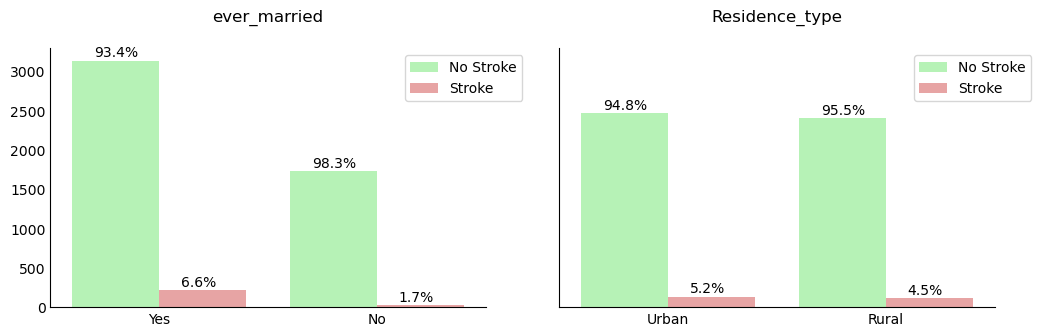

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

for i, col in enumerate(binary_features[2:4]):
    create_catplot(df=stroke_df, ax=axes[i], col=col, hue_col="stroke", colors=['palegreen', 'lightcoral'])
    find_percentages_with_hue(ax=axes[i], col=stroke_df[col])

    axes[i].legend(["No Stroke", "Stroke"], bbox_to_anchor=(1.1,1))
    axes[i].set(title=f"{col}\n")

plt.tight_layout(pad=3)

**The type of residence have no apperent influence on strokes**, however the ever **being married seems to increase the chances**.

There might be some **correlation of being married with age**, or with the consumption of more food and increase of other problems (i.e heart diseases and hypertension).

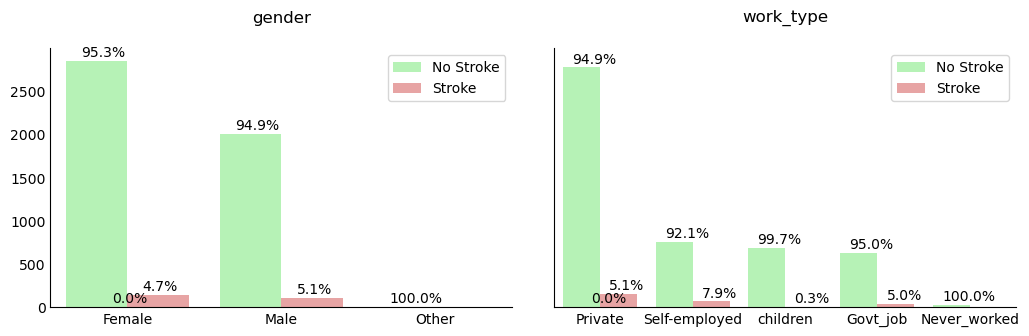

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)

for i, col in enumerate(cat_features[:2]):
    create_catplot(df=stroke_df, ax=axes[i], col=col, hue_col="stroke", colors=['palegreen', 'lightcoral']) 
    axes[i].legend(["No Stroke", "Stroke"], loc="upper right")
    axes[i].set(title=f"{col}\n")

find_percentages_with_hue(ax=axes[0], col=stroke_df[cat_features[0]], Number_of_categories=3)
find_percentages_with_hue(ax=axes[1], col=stroke_df[cat_features[1]], Number_of_categories=5)

plt.tight_layout(pad=3)

**Gender does not seem to be** a feature that descriminate a person having a stroke or not. The chances of stroke on male individuals is only slightly higher than on females.

In general terms, a person who is self employed seems to have strokes more likely (but only slightly more) than in other sectors/childen.

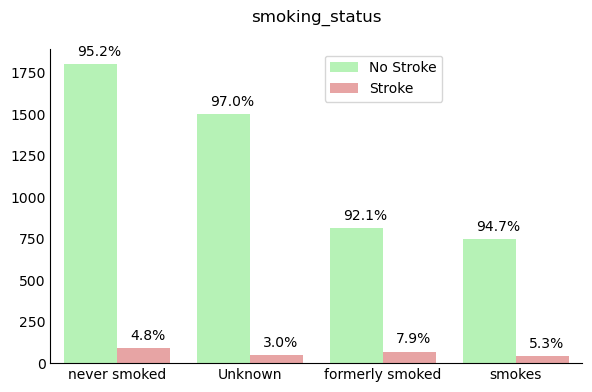

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

create_catplot(df=stroke_df, ax=axes, col=cat_features[2], hue_col="stroke", colors=['palegreen', 'lightcoral'])
find_percentages_with_hue(ax=axes, col=stroke_df[cat_features[2]], Number_of_categories=4)

axes.legend(["No Stroke", "Stroke"], bbox_to_anchor=(0.75,1))
axes.set(title=f"{cat_features[2]}\n")
plt.tight_layout(pad=1)

**Formely smokers apperantly are the most likely to have strokes**, but only slightly more that non-smokers and current smokers.

This is even harder to evaluate then the other features, because you cannot know if formely smoking is a previous event in relation to having the stroke or nor.

<h2 style="color:#C1524B">Correlation of Features</h2>

Before showing the heatmap, we run a simple label enconder on the features.

In [ ]:
encoder = LabelEncoder()
stroke_df_enc = stroke_df.apply(encoder.fit_transform)
stroke_df_enc.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,88,0,1,1,2,1,3850,239,1,1
51676,0,82,0,0,1,3,0,3588,418,2,1
31112,1,101,0,1,1,2,0,2483,198,2,1
60182,0,70,0,0,1,2,1,3385,217,3,1
1665,0,100,1,0,1,3,0,3394,113,2,1


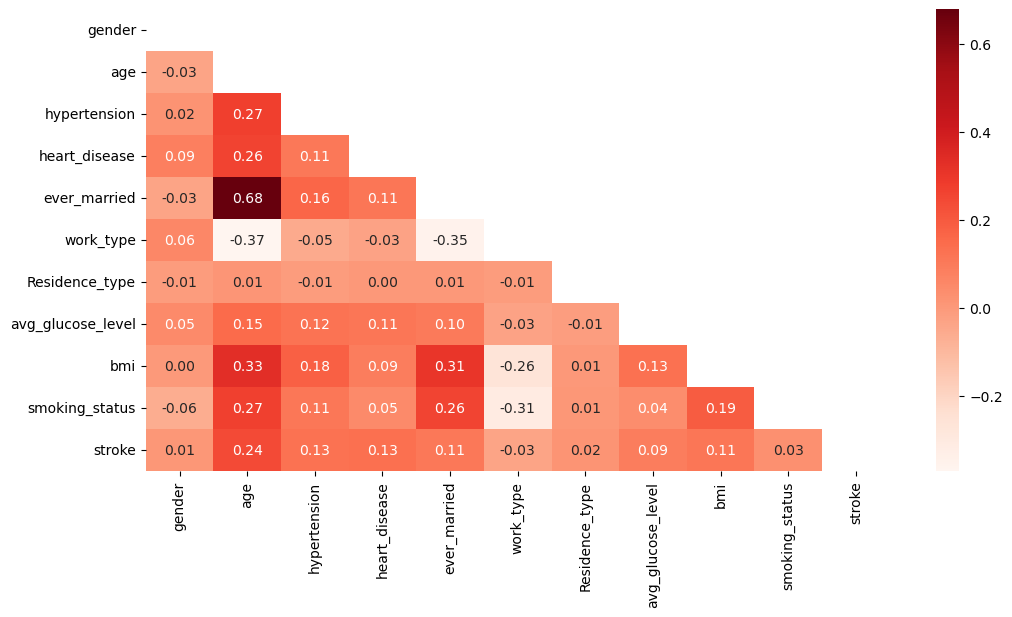

In [ ]:
matrix = np.triu(stroke_df_enc.corr())

plt.figure(figsize=(12,6))
sns.heatmap(stroke_df_enc.corr(),cmap="Reds", annot=True, mask=matrix, fmt=".2f");

This heatmap highlights:
- the relationship between **ever_married and age** (68% correlation).
- some **negative correlations between work_type** and, bmi, smoking_status and ever_married. This is probably due to the children category presented in work_type, or due to the high cardinality of this feature.

- In general terms **stroke present some positively moderate correlation only with age**. 

<h2 style="color:#C1524B">Univariate Feature Importance</h2>

In this section, we run a simple test to **find out the features that have most importance for  the target** variable. 

We can assume that the **higher the score in the SelektKBest, the higher the importance** of the feature. However, this is a individual analysis of feature-i and target, **in reality** due to the interaction between features **the results of a multivariate importance can be very differen**t.

Due to the **categorical nature** of the features, this importance is evaluated through a **chi-squared test**.

In [ ]:
X = stroke_df_enc.drop('stroke', axis=1)
y = stroke_df_enc['stroke']

bestfeature = SelectKBest(score_func=chi2, k='all')
bf = bestfeature.fit(X, y)

In [ ]:
score = pd.DataFrame(bf.scores_)
colnames = pd.DataFrame(X.columns)
bf_result = pd.concat([colnames, score], axis='columns')
bf_result.columns = ['Feature','Score']
bf_result.nlargest(10,'Score')

,Feature,Score
7,avg_glucose_level,26137.211
8,bmi,3077.755
1,age,2493.466
3,heart_disease,87.987
2,hypertension,75.449
4,ever_married,20.623
9,smoking_status,3.369
5,work_type,2.926
6,Residence_type,0.601
0,gender,0.239


According to the SelectKBest algorithm, **avg_glucose_level, bmi and age are the most influencing features** on strokes.

Again, the features were evaluated separately, after the modeling this order can change a lot.

<h2 style="color:#C1524B">Outliers Detection</h2>

Let's take a look at the dataset outliers for the numerical features.

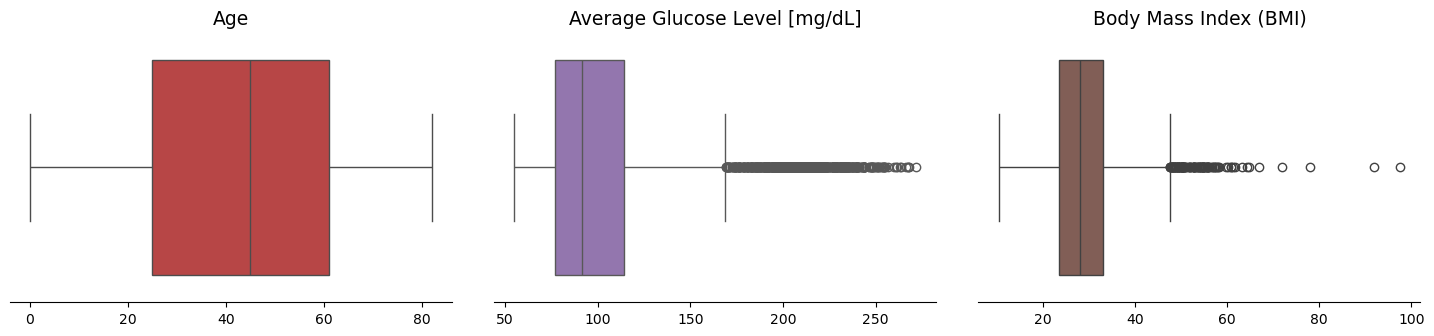

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(num_features):
    sns.boxplot(data=stroke_df, x=col, ax=axes[i], color=palette_plt[i+3], saturation=0.65)
    sns.despine(left=True)
    
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticklabels("")
    axes[i].tick_params(axis='y',length=0)

axes[0].set_title("Age", fontsize=13.5)
axes[1].set_title("Average Glucose Level [mg/dL]", fontsize=13.5)
axes[2].set_title("Body Mass Index (BMI)", fontsize=13.5)

plt.tight_layout(pad=3)

As exposed **Average Glucose Level and Body Mass Index present a lot of outliers**. It would however be **innapropriate to delete/change the values of these outliers**, since they represent measured data (that is **probably highly related** to strokes).

<p style = "background:	#f6eeee; color:black"> The EDA provided some <b>good insights about the features</b> that are most likely important to the prediction of strokes, i.e. Age, Glucose Levels, BMI, Hypertension and Heart Disease.<br><br>
Let's now check how a baseline model would score on our original dataset after train test separation</p>

<h1 style="color:#C1524B">Baseline Model</h1>

**Model at random guessing** would score for our dataset.

In [ ]:
X = stroke_df.drop('stroke', axis=1)
y = stroke_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5026908023483366

For this baseline model a **50% accuracy** was obtained. 

Let's check the accuracy as well for a **logistic model**, for a simple encoder was applied to the X train data so that the model could interpret the categorical classes.

In [ ]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X_train.apply(encoder.fit_transform), y_train)
print(logreg.score(X_train.apply(encoder.fit_transform), y_train))

yhat_train = logreg.predict(X_train.apply(encoder.fit_transform))
report = classification_report(y_train, yhat_train)
print(report)

0.9527886497064579
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3899
           1       0.33      0.02      0.04       189

    accuracy                           0.95      4088
   macro avg       0.64      0.51      0.51      4088
weighted avg       0.93      0.95      0.93      4088



As expected the **accurary** for a model not at random is much higher **95%**. Which can be obtained simply by having **most of the dataset to the dominant class**.

This is highlightened by the **levels of precision, recall and f1-score, almost 0**.

This is also a **clear indication** that this **unbalancing** in the data **should be treated before the modeling** phase.

<h1 style="color:#C1524B">Feature Preprocessing</h1>

<h2 style="color:#C1524B">Preprocessing Pipeline</h2>

Let's start by defining our features again

In [ ]:
num_features = ["age", "avg_glucose_level", "bmi"]
binary_features = ["hypertension", "heart_disease", "ever_married", "Residence_type", "gender"]
cat_features = ["work_type", "smoking_status"]

Here the **train and test dataset are separated**. Later on a **Cross-Validation procedure** will be employed in the modeling section, that is why a specific validation dataset will not be separated here. An advantage from this choice is obtained as our data is not huge (ca. 5000 patients)

In [ ]:
X = stroke_df.drop('stroke', axis=1)
y = stroke_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In machine learning, data preprocessing is crucial. We often use **pipelines to automate** these processes. Here, we have **three transformers** designed to prepare different types of features for modeling.

It includes some imputing median values for numerical columns and the most frequent for the categorical ones. Besides, there will be scaling of the numerical and simple encoding the binary features. A OneHotEncoder will be used on the categorical features with higher cardinality.

A reduction of cardinality was also attempted, but not carried on (only one class was being transformed for a 5% attribution for rare classes)


In [ ]:
# Define transformations to features
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

binary_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ]
)

cat_transformer = Pipeline(
    steps=[
        ("cat_mode_imputer", CategoricalImputer(imputation_method="frequent", ignore_format=True)),
        ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore')),
    ]
)

In [ ]:
# Define the preprocess pipeline and fit the data
preprocess_pipe = ColumnTransformer(
   transformers=[
       ('numeric', num_transformer, num_features),
       ('binary', binary_transformer, binary_features),
       ('categorical', cat_transformer, cat_features)
])

preprocess_pipe.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'avg_glucose_level', 'bmi']),
                                ('binary',
                                 Pipeline(steps=[('cat_mode_imputer',
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['hypertension', 'heart_disease',
                                  'ever_married', 'Residence_type', 'gender']),
                                ('categorical',
                                 Pipeline(steps=[('cat_mode_imputer',
                                                  CategoricalImputer(ignore_format=True,
                                                                     imputation_method='frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['work_type', 'smoking_status'])])

<h2 style="color:#C1524B">Features' Names</h2>

To **keep track of the features** of our system and what our dataframe looks like, we will integrate to the pipeline a custom tranformation to merge the features names.

In [ ]:
class ApplyColumnNamesTransformer:
    ''' Reaply features names to preprocessed array. '''
    def __init__(self, preprocess_pipe, cat_features, num_features, binary_features):
        self.preprocess_pipe = preprocess_pipe
        self.cat_features = cat_features
        self.num_features = num_features
        self.binary_features = binary_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        one_hot_feature_names = self.preprocess_pipe.transformers_[2][1].named_steps["one_hot_encoder"].get_feature_names_out(self.cat_features)
        all_feature_names = np.concatenate((self.num_features, self.binary_features, one_hot_feature_names))
        X_df = pd.DataFrame(X, columns=all_feature_names)
        return X_df

In [ ]:
full_preprocess_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('apply_column_names', ApplyColumnNamesTransformer(preprocess_pipe, cat_features, num_features, binary_features))
])

In [ ]:
full_preprocess_pipe.fit(X_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('binary',
                                                  Pipeline(steps=[('cat_mode_imputer',
                                                                   CategoricalImputer(ignore_format=True,
                                                                                      imputation_method='frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(ha...
                                                   'heart_disease',
                                                   'ever_married',
                                                   'Residence_type',
                                                   'gender']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_mode_imputer',
                                                                   CategoricalImputer(ignore_format=True,
                                                                                      imputation_method='frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['work_type',
                                                   'smoking_status'])])),
                ('apply_column_names',
                 <__main__.ApplyColumnNamesTransformer object at 0x000001CE01734F70>)])

In [ ]:
X_train_prep_df = full_preprocess_pipe.transform(X_train)
print(X_train_prep_df.shape, y_train.size)
X_train_prep_df.head(3)

(4088, 17) 4088


,age,avg_glucose_level,bmi,hypertension,heart_disease,ever_married,Residence_type,gender,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.526,-0.709,-0.116,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
1,0.526,2.770,-0.858,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,-0.403,1.517,-0.767,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000


<h2 style="color:#C1524B">Oversampling with SMOTE</h2>

As mentioned, the data is unbalanced, the **95% of patients present no stroke** so we are going to oversample the minority class. **SMOTE (Synthetic Minority Oversampling Technique)** is a technique used in machine learning to tackle the class imbalance problem by generating synthetic examples for the minority class. It mitigates performance issues caused by having far fewer data points in the minority class compared to the majority class.

This part of the pipeline will be kept separate, because there **no reason to oversample our unseen data (test)**.

In [ ]:
full_preprocess_pipe_SMOTE = ImbPipeline([
    ('preprocess', preprocess_pipe),
    ('apply_column_names', ApplyColumnNamesTransformer(preprocess_pipe, cat_features, num_features, binary_features)),
    ("SMOTE", SMOTE(sampling_strategy='auto', random_state=1)),
])

X_train_resampled, y_train_resampled = full_preprocess_pipe_SMOTE.fit_resample(X_train, y_train)

In [ ]:
print(f"The shape of resampled is {X_train_resampled.shape}, while the original train is {X_train.shape}\n")
print(f"The proportion of data in the target is:\n{y_train_resampled.value_counts()}")
X_train_resampled.head(3)

The shape of resampled is (7798, 17), while the original train is (4088, 10)

The proportion of data in the target is:
0    3899
1    3899
Name: stroke, dtype: int64


,age,avg_glucose_level,bmi,hypertension,heart_disease,ever_married,Residence_type,gender,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.526,-0.709,-0.116,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
1,0.526,2.770,-0.858,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
2,-0.403,1.517,-0.767,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000


Now the percentage of the patients with stroke and no stroke is 50% and 50%. Let's model!!!

<h1 style="color:#C1524B">Model Selection</h1>

The following modeling solutions were defined. We start off by **setting the hyperparameters for the GridSearch** for each of the defined models. The GridSearch is the responsible to find the best hyperparameters for each model while **it performs a cross-validation**. We used 7 cross-folds.

In [ ]:
param_grids = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10]
    },
    'DecisionTree': {
        'model__max_depth': [2, 4, 5],
        'model__min_samples_leaf': [30, 50, 100]
    },
    'RandomForest': {
        'model__n_estimators': [10, 20, 50],
        'model__max_depth': [2, 4, 5],
        'model__min_samples_leaf': [15, 30, 50, 100]
    },
    'XGBoost': {
        'model__n_estimators': [10, 20, 50],
        'model__learning_rate': [0.01, 0.05],
        'model__max_depth': [2, 4, 5],
        #'min_child_weight': [5, 15, 100]
    }
}

models = [
    ('LogisticRegression', LogisticRegression(random_state=1)),
    ('DecisionTree', DecisionTreeClassifier(random_state=1)),
    ('RandomForest', RandomForestClassifier(random_state=1)),
    ('XGBoost', XGBClassifier(random_state=1)),
]

In [ ]:
results = {}

# Iterate through the models and train them using grid search
for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])
    
    param_grid = param_grids.get(model_name, {})
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=7, scoring='f1')
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    results[model_name] = {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

In [ ]:
#results

In [ ]:
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

LogisticRegression: 0.785
DecisionTree: 0.828
RandomForest: 0.847
XGBoost: 0.895


After oversampling our data, the results of the trained models present a much higher f1-score than before (reference to log model on train data only encoded). The best results during cross-validation were obtained by the ensemble models: RandomForest and XGBoost.

Let's evaluate these models first based on their f1-score and recall and then jump to the confusion matrices.

In [ ]:
logreg_model = results['LogisticRegression']['model'].named_steps['model']
dt_model = results['DecisionTree']['model'].named_steps['model']
rf_model = results['RandomForest']['model'].named_steps['model']
xgb_model = results['XGBoost']['model'].named_steps['model']

y_logreg = logreg_model.predict(X_train_resampled)
y_dt = dt_model.predict(X_train_resampled)
y_rf = rf_model.predict(X_train_resampled)
y_xgb = xgb_model.predict(X_train_resampled)

In [ ]:
models = {
    'LogisticRegression': y_logreg,
    'DecisionTree': y_dt,
    'RandomForest': y_rf,
    'XGBoost': y_xgb
}

for model_name, y_pred in models.items():
    f1 = f1_score(y_train_resampled, y_pred)
    recall = recall_score(y_train_resampled, y_pred)
    
    print(f"{model_name}")
    print(f"F1-Score: {f1:.2f} ; Recall: {recall:.2f}\n")

LogisticRegression
F1-Score: 0.79 ; Recall: 0.82

DecisionTree
F1-Score: 0.83 ; Recall: 0.92

RandomForest
F1-Score: 0.85 ; Recall: 0.93

XGBoost
F1-Score: 0.91 ; Recall: 0.95



As expected, our f1-values are slightly changed due to the fact that the previous scorings were made in a cross-validation setup. And here the full training data is provided.

Besides, it seems that our **ensemble models are overfitting the data** (inspite all of the restrictions imposed). We probably cannot expect good predicting values from them on unseen data.

Let's see the results in a **confusion matrix**. The values exposed there are normalized and represent percentages in relation to true values.

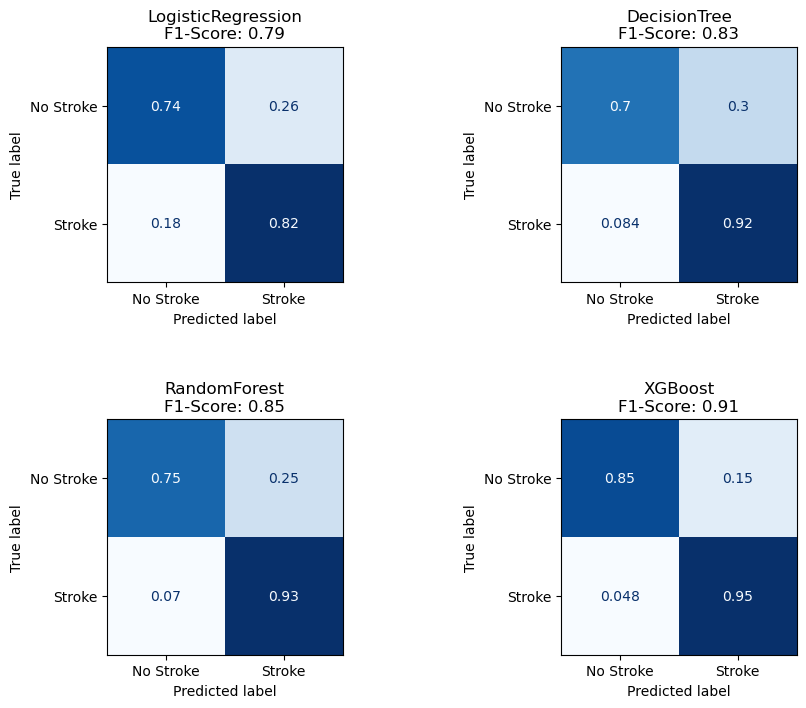

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models.keys(), models.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred, normalize='true',
                                                                  cmap='Blues', ax=ax, colorbar=False, 
                                                                  display_labels=["No Stroke", "Stroke"])
    f1 = f1_score(y_train_resampled, y_pred)
    ax.set_title(f"{model_name}\nF1-Score: {f1:.2f}")

plt.tight_layout(pad=4)

In the **medical domain**, it is often preferred to **prioritize models with very high recall** over precision due to the critical nature of healthcare and the consequences of false negatives. This garantees that all the pacients that have an actual risk of having a stroke will be informed and further treated.

If the model includes some no-risk patients as risky (False Positives), that is not as problematic as not recognizing the potential patients that could have a stroke.

For the ***Decision Tree, Random Forest and XGBoo**t models, **between 5% to 8% of the patients will not be identified as risky** and thus not notified. This value goes to 18% for the Logistic Regression model.

**Based solely on that (Recall / False Negatives)** we would be inclined to **choose one of the 3 last models**, however they are most likely to **overfit** the data.

 Let's check the results in a **ROC_AUC Curve** to have another visual representation of the results.

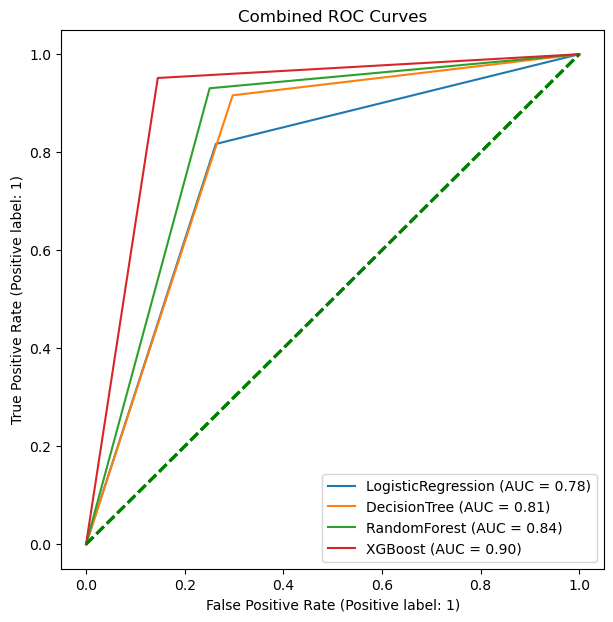

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
roc_displays = []

for model_name, y_pred in models.items():
    roc_display = RocCurveDisplay.from_predictions(y_train_resampled, y_pred, name=model_name, ax=ax)
    roc_displays.append(roc_display)
    ax.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

ax.set_title("Combined ROC Curves");

We see in this graph that the more harmonic values between the False Positive Rate and True Positive Rate (Recall) was obtained by the XGBoost.

Let's see some **features importance** for some of these models. Starting off by checking the tree for the decision tree model.

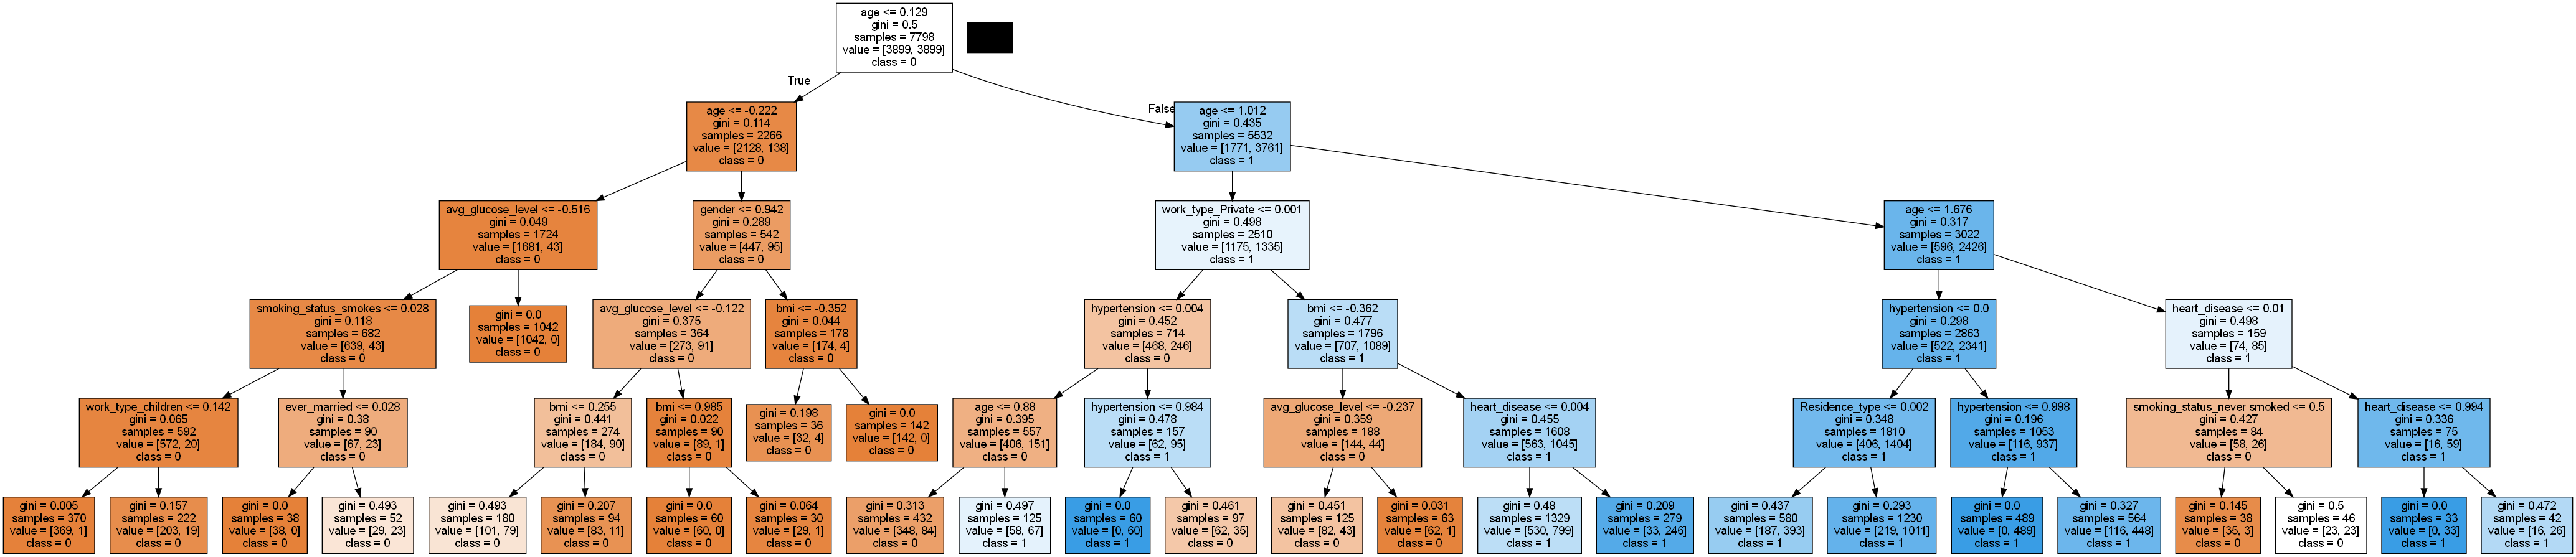

In [ ]:
# Create DOT data
dot_data = export_graphviz(dt_model,
                           out_file=None,
                           feature_names=X_train_resampled.columns,
                           class_names=y_train_resampled.unique().astype(str).tolist(),
                           filled = True)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Full picture will be shown during presentation!!**

As observed the decision tree model make the cuts of the 2 upper levels based on **age**, hence the importance of this feature.

Down on the order of importance for this model are: **avg_glucose_lvl, gender, work_type_Private** (not in order!!).

**We can also assume that the other tree model based would make similar choices** (Random Forest and XGBoost).

Let's see a **permutation importance for the logistic regression**.

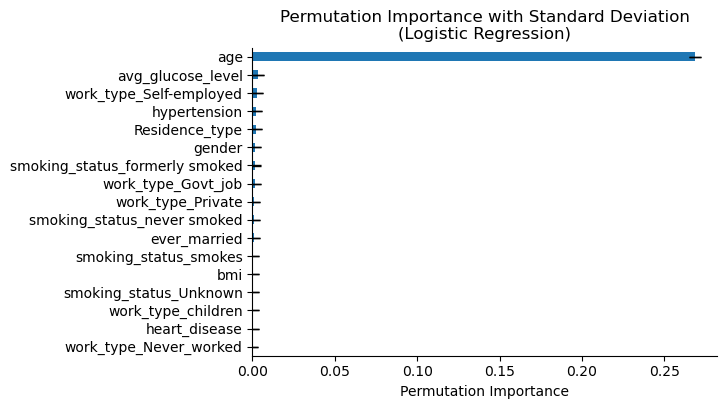

In [ ]:
result = permutation_importance(logreg_model, X_train_resampled, y_train_resampled, n_repeats=50, random_state=1)

feature_importance = pd.DataFrame(
    {
        "Feature": X_train_resampled.columns,
        "Importance": result.importances_mean,
        "Standard Deviation": result.importances_std,
    }
)
mask = feature_importance['Importance']<0
feature_importance['Importance'][mask] = feature_importance['Importance'][mask] * -1
feature_importance = feature_importance.sort_values("Importance", ascending=True)

ax = feature_importance.plot(
    x="Feature",
    y="Importance",
    kind="barh",
    color="tab:blue",
    figsize=(6, 4),
    yerr="Standard Deviation",
    capsize=4,
)

sns.despine()
ax.set(
    ylabel="",
    xlabel="Permutation Importance",
    title="Permutation Importance with Standard Deviation\n(Logistic Regression)",
)
ax.legend([], frameon=False);

We see that **for our simplest model**, the feature that **mainly influenced** the possibility of a stroke was the **age**.

Let's plot the target versus age and see how it looks.

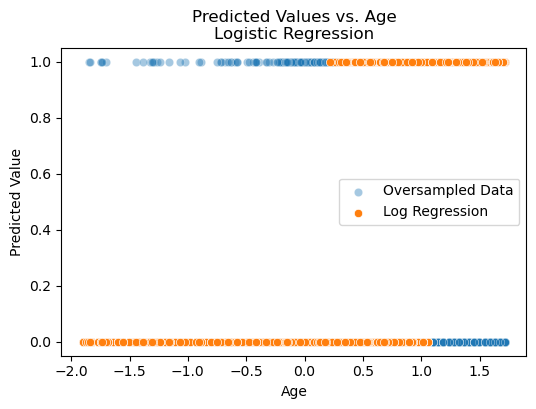

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.scatterplot(x=X_train_resampled["age"], y=y_train_resampled, alpha=0.4, ax=ax)
sns.scatterplot(x=X_train_resampled["age"], y=y_logreg, ax=ax)

ax.legend(["Oversampled Data", "Log Regression"])
plt.title("Predicted Values vs. Age\nLogistic Regression")
plt.xlabel("Age")
plt.ylabel("Predicted Value");

We see that **age can in fact explain a lot** of what is going on, however there are some patients of young age who had stroke and (obviously) some old age patients that did not.

For the features importance in our **XGBoost we will use the library SHAP** (SHapley Additive exPlanations), which is a unified approach to explain the output of any machine learning model based on game theory.

In [ ]:
shap.initjs()

# Calculate SHAP values for your data
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_resampled)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_resampled.iloc[0,:])


The above shows the features contributing to take the SHAP value to the right/left. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Bellow we see the importance of the feature in absolute SHAP value.

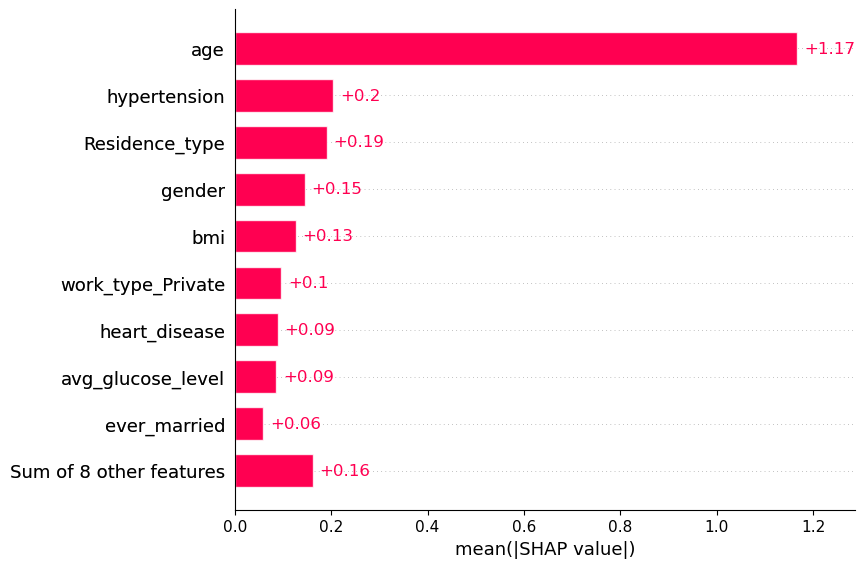

In [ ]:
shap.plots.bar(explainer(X_train_resampled))

**Age is the most important feature, followed by hypertension and Residence type**.

Another way to see the importance is in the **graph bellow**. It shows additionally how the **importance of the feature changes with the increase on its values**.

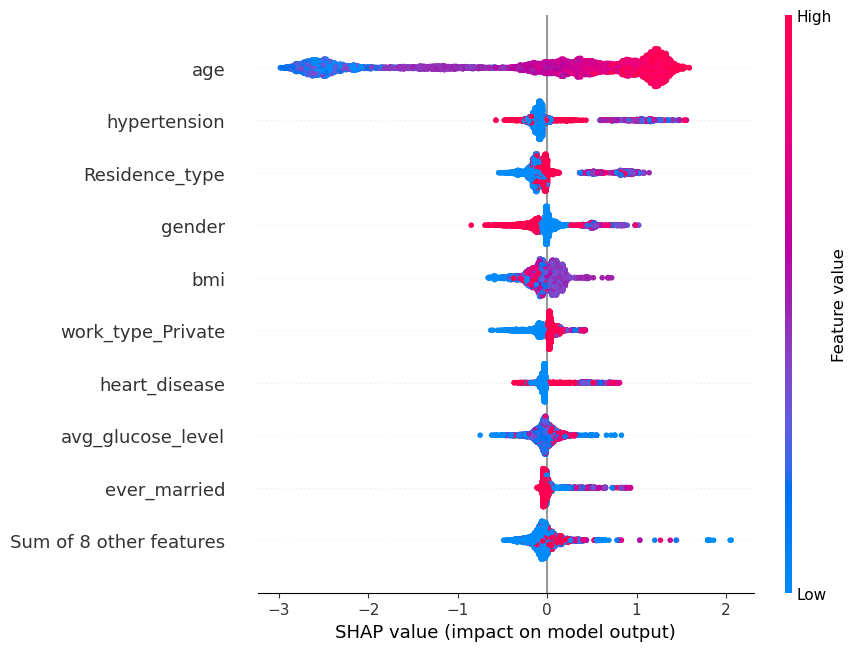

In [ ]:
shap.plots.beeswarm(explainer(X_train_resampled), plot_size=0.6)

This shows clearly that the increase in age values results in a high impact on the model.

For hypertension this is not so clear, it seems that some high values of this feature impacted the model a lot (right part), but also in the left we see individuals with high hypertension and low impact.

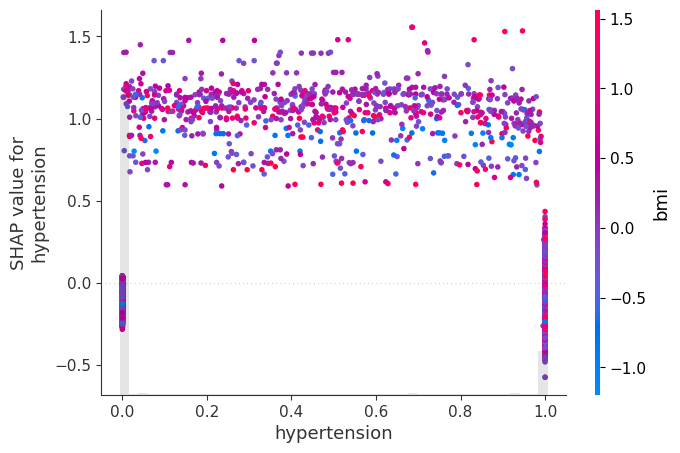

In [ ]:
shap.plots.scatter(explainer(X_train_resampled)[:,'hypertension'], color=explainer(X_train_resampled)[:,"bmi"])

Above we see a scatter plot of the hypertension and SHAP values, colored by BMI.

We see that mostly individuals with high BMI had a high impact on the model, we also see a tendency for individuals with no Hypertension (class 0) to have low influence of the model.

<p style = "background:	#f6eeee; color:black"> This modeling section highlighted the features that had most importance for the model, and also the evaluation of the models themselves.<br><br>
<b>The most important feature is by far the 'age'</b>, followed in some models by 'hypertension', 'glucose_levels'. <b>Some feature engineering is required</b> specially on those features to increase the predicting power of the models.<br><br>
At this stage the <b>logistic model will be chosen as the final model</b>. <br>Inspite the lowest scores obtained, there are two main reasons for that. <b>First, it is a simpler model</b>, which can be explained easily; second, <b>it has a much lower chance to overfit our test data</b>.</p>

<h1 style="color:#C1524B">Final Model Evaluation</h1>

So, we have selected our Logistic Regression as our model and we will now transform the test data to it.

This transformation will be used exclusevely with the full_preprocess_pipe (no oversampling of test data).

In [ ]:
X_test_prep = full_preprocess_pipe.transform(X_test)
print(X_test_prep.shape, y_test.size)
X_test_prep.head()

(1022, 17) 1022


,age,avg_glucose_level,bmi,hypertension,heart_disease,ever_married,Residence_type,gender,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,-0.049,0.161,1.082,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1,1.543,-0.604,0.158,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
2,-0.668,-0.715,-0.454,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000
3,1.676,3.105,-1.014,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000
4,0.393,-0.190,-0.116,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000


In [ ]:
yhat_test = logreg_model.predict(X_test_prep)
report = classification_report(y_test, yhat_test, target_names=["No Stroke", "Stroke"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   No Stroke       0.98      0.73      0.84       962
      Stroke       0.16      0.80      0.26        60

    accuracy                           0.73      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.73      0.80      1022



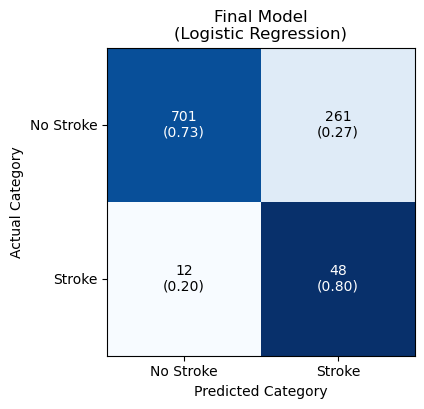

In [ ]:
cm = confusion_matrix(y_test, yhat_test)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=False,
                                figsize=(4, 4))

plt.xticks(np.arange(2), ["No Stroke", "Stroke"])
plt.yticks(np.arange(2), ["No Stroke", "Stroke"])

ax.set(ylabel="Actual Category", xlabel="Predicted Category", title="Final Model\n(Logistic Regression)",);

So, we can see that our final model has a **recall of 80%**, which more than I was expecting!

The problem in the current model is that about 27% of non risk patients would also be notified. :/

It shows again the importance of age on having a stroke.

In [ ]:
import joblib
joblib.dump(preprocess_pipe, 'preprocess_pipe.pkl')
joblib.dump(full_preprocess_pipe, 'full_preprocess_pipe.pkl')
joblib.dump(full_preprocess_pipe_SMOTE, 'full_preprocess_pipe_SMOTE.pkl')

['full_preprocess_pipe_SMOTE.pkl']

<h1 style="color:#C1524B">Conclusion </h1>

A model to predict classification problem was developped and a full exploratory analysis of the dataset was carried out.

Our **simplest model (logistic regression)** was choosen as the final model. It obtained a recall of 80%. That means that our model would be able to identify and inform a doctor about **8 out of 10 patients with risk of stroke**.

**The drawback of this model are the 27% of False Positive**.

Some points for improvement:
- Some feature engineering should be made on the most important features.
- Deployment of the model.